In [102]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [103]:
def sma(ticker_in, start_date_in, end_date_in):
  ticker = ticker_in
  start_date = start_date_in
  end_date = end_date_in

  df=yf.download(ticker, start = start_date, end = end_date, interval = "1d")
  df.reset_index(inplace = True)
  df.columns = df.columns.get_level_values(0)


  df['SMA_5'] = df['Close'].rolling(window = 5).mean()
  df['SMA_50'] = df['Close'].rolling(window = 50).mean()

  df['indicator'] = 0
  df.loc[df['SMA_5'] > df['SMA_50'], 'indicator'] = 1
  df.loc[df['SMA_5'] < df['SMA_50'], 'indicator'] = -1
  df['dec'] = df['indicator'].diff()
  return df

In [104]:
def ema(ticker_in, start_date_in, end_date_in):
  ticker = ticker_in
  start_date = start_date_in
  end_date = end_date_in

  df=yf.download(ticker, start = start_date, end = end_date, interval = "1d")
  df.reset_index(inplace = True)
  df.columns = df.columns.get_level_values(0)


  #EMA
  df['ema'] = df['Close'].ewm(com=0.8).mean() #ref: https://www.geeksforgeeks.org/python/how-to-calculate-an-exponential-moving-average-in-python/

  df['indicator'] = 0
  df.loc[df['Close'] > df['ema'], 'indicator'] = 1
  df.loc[df['Close'] < df['ema'], 'indicator'] = -1
  df['dec'] = df['indicator'].diff()
  return df


In [105]:
def mock_trading(df, initial_cash=10000):

    cash = initial_cash
    shares = 0
    portfolio_value = []
    share_num = []

    for i, row in df.iterrows():
        price = row['Close']

        # BUY signal
        if row['dec'] == 2 and cash >= price:
            shares_to_buy = cash // price
            cash -= shares_to_buy * price
            shares += shares_to_buy

        # SELL signal
        elif row['dec'] == -2 and shares > 0:
            cash += shares * price
            shares = 0

        share_num.append(shares)
        portfolio_value.append(cash + shares * price)

    df['share_num'] = share_num
    df['portfolio_value'] = portfolio_value
    df['daily_return'] = df['portfolio_value'].pct_change()

    total_return = df['portfolio_value'].iloc[-1] / df['portfolio_value'].iloc[0] -1

    return df, total_return



In [106]:
ticker_in = "GOOG"
start_date_in = "2025-01-01"
end_date_in = "2026-02-06"

In [107]:
df_ema = ema(ticker_in, start_date_in, end_date_in)
mock_trading(df_ema, initial_cash=10000)

/tmp/ipython-input-4058617035.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df=yf.download(ticker, start = start_date, end = end_date, interval = "1d")
[*********************100%***********************]  1 of 1 completed


(Price       Date       Close        High         Low        Open    Volume  \
 0     2025-01-02  189.890732  192.450757  187.978179  190.742412  17545200   
 1     2025-01-03  192.381042  193.745725  190.607947  191.977614  12875000   
 2     2025-01-06  197.192322  198.786108  194.303559  194.393206  19483300   
 3     2025-01-07  195.947159  201.356094  195.180141  197.501107  16966800   
 4     2025-01-08  194.632294  196.873568  192.998654  193.197875  14335300   
 ..           ...         ...         ...         ...         ...       ...   
 269   2026-01-30  338.529999  340.290009  332.640015  334.459991  21740200   
 270   2026-02-02  344.899994  345.165009  336.010010  336.549988  22775200   
 271   2026-02-03  340.700012  350.149994  338.589996  348.515015  25786500   
 272   2026-02-04  333.339996  344.250000  329.369995  343.755005  36991100   
 273   2026-02-05  331.329987  332.644012  306.920013  313.200012  51842000   
 
 Price         ema  indicator  dec  share_num  por

In [108]:
df_sma = sma(ticker_in, start_date_in, end_date_in)
mock_trading(df_sma, initial_cash=10000)

/tmp/ipython-input-1253878050.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df=yf.download(ticker, start = start_date, end = end_date, interval = "1d")
[*********************100%***********************]  1 of 1 completed


(Price       Date       Close        High         Low        Open    Volume  \
 0     2025-01-02  189.890732  192.450757  187.978179  190.742412  17545200   
 1     2025-01-03  192.381042  193.745725  190.607947  191.977614  12875000   
 2     2025-01-06  197.192322  198.786108  194.303559  194.393206  19483300   
 3     2025-01-07  195.947159  201.356094  195.180141  197.501107  16966800   
 4     2025-01-08  194.632294  196.873568  192.998654  193.197875  14335300   
 ..           ...         ...         ...         ...         ...       ...   
 269   2026-01-30  338.529999  340.290009  332.640015  334.459991  21740200   
 270   2026-02-02  344.899994  345.165009  336.010010  336.549988  22775200   
 271   2026-02-03  340.700012  350.149994  338.589996  348.515015  25786500   
 272   2026-02-04  333.339996  344.250000  329.369995  343.755005  36991100   
 273   2026-02-05  331.329987  332.644012  306.920013  313.200012  51842000   
 
 Price       SMA_5      SMA_50  indicator  dec  sh

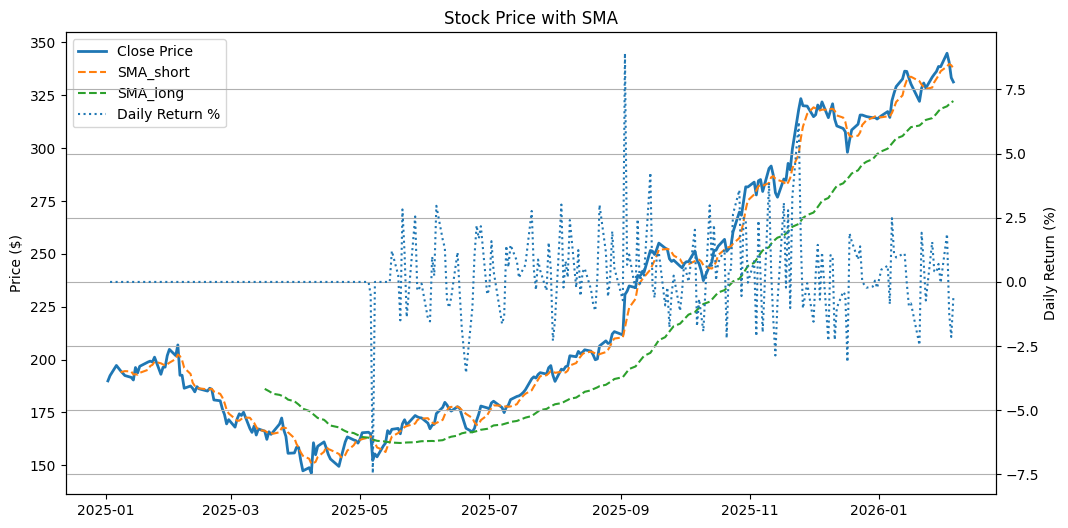

In [119]:
#SMA plot
df, total_return = mock_trading(df_sma, initial_cash=10000)
fig, ax1 = plt.subplots(figsize=(12,6))

#left for sma
ax1.plot(df['Date'], df['Close'], label='Close Price', linewidth=2)
ax1.plot(df['Date'], df['SMA_5'], label='SMA_short', linestyle='--')
ax1.plot(df['Date'], df['SMA_50'], label='SMA_long', linestyle='--')
ax1.set_ylabel('Price ($)')

#right for profit
ax2 = ax1.twinx()
ax2.plot(df['Date'], df['daily_return']*100, label='Daily Return %', linestyle=':')
ax2.set_ylabel('Daily Return (%)')


#legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')


plt.xlabel('Date')
plt.title('Stock Price with SMA')
plt.grid(True)

plt.show()





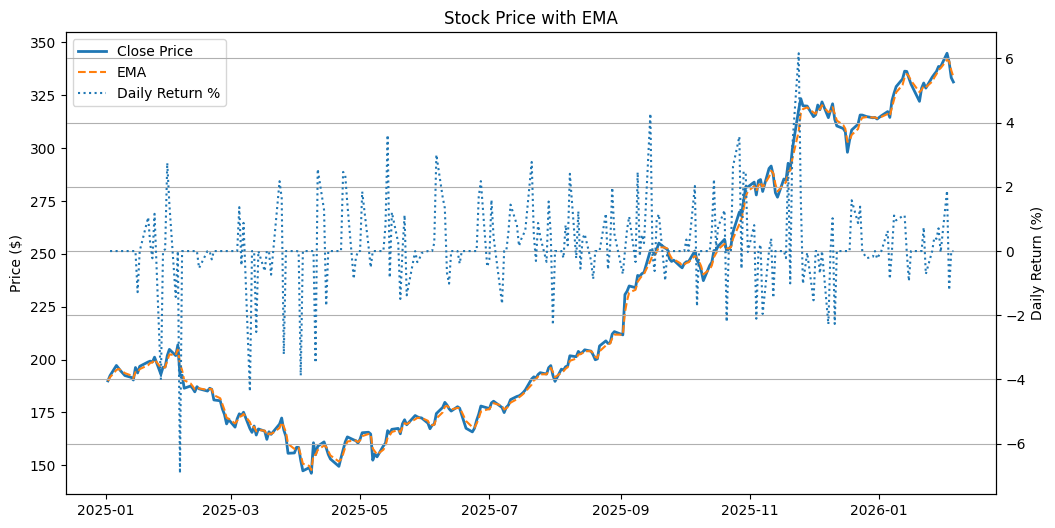

In [117]:
#EMA plot
df, total_return = mock_trading(df_ema, initial_cash=10000)
fig, ax1 = plt.subplots(figsize=(12,6))

#left for ema
ax1.plot(df['Date'], df['Close'], label='Close Price', linewidth=2)
ax1.plot(df['Date'], df['ema'], label='EMA', linestyle='--')
ax1.set_ylabel('Price ($)')

#right for profit
ax2 = ax1.twinx()
ax2.plot(df['Date'], df['daily_return']*100, label='Daily Return %', linestyle=':')
ax2.set_ylabel('Daily Return (%)')


#legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')


plt.xlabel('Date')
plt.title('Stock Price with EMA')
plt.grid(True)

plt.show()